In [25]:
import pandas as pd
import numpy as np
from gensim import corpora
from tqdm import tqdm
import matplotlib.pyplot as plt

## Step 1. Downloading dataset

In [12]:
# download data from Kaggle (https://www.kaggle.com/datasets/hwassner/TwitterFriends)
df = pd.read_json('data_twitter.json')
df.head(2)

avatar  followersCount  \
0  http://pbs.twimg.com/profile_images/5342862178...             319   
1  http://pbs.twimg.com/profile_images/7619776021...             275   

                                             friends  friendsCount  \
0  [1969574754, 1969295556, 1969284056, 196961221...           112   
1  [60789485, 2420931980, 2899776756, 127410795, ...           115   

           id lang       lastSeen       screenName               tags  \
0  1969527638   en  1472271687519  LlngoMakeEmCum_  [#nationaldogday]   
1    51878493   en  1472270622663     _notmichelle  [#nationaldogday]   

              tweetId  
0  769310701580083200  
1  769309490038439936

## Step 2. Pre-processing

In [13]:
# identify id whose following lists is empty
id_length_0 = []     
for i in range(len(df)):
    length = len(df['friends'][i])
    if length == 0:
        id_length_0.append(i)
    else:
        pass
print('number of empty following lists in this dataset:', len(id_length_0))

# delete empty following list
df = df.drop(labels = id_length_0, axis=0)
df.index = range(len(df))

# following_lists: 
f_lists = df['friends']
print(f_lists.head(5))

number of empty following lists in this dataset: 87
0    [1969574754, 1969295556, 1969284056, 196961221...
1    [60789485, 2420931980, 2899776756, 127410795, ...
2    [361335082, 1405248468, 24626354, 725675895965...
3    [1571896093, 768938323612008448, 2548665930, 3...
4    [2432417994, 752203567382093824, 7421603779164...
Name: friends, dtype: object


In [23]:
# original dictionary (i.e., GENSIM object that consists of the collection of unique followee IDs) in our dataset; 
dictionary = corpora.Dictionary(f_lists, prune_at = 50000000) 

# filter less popular items and extremely short lists in our dataset (frequency < 5)
dictionary.filter_extremes(no_below = 5, keep_n = 50000000)
Iu = [dictionary.doc2idx(user) for user in f_lists]
Iu_new = []
for u_list in tqdm(Iu):
    if len(u_list) > 10:
        u_list_new = []
        for j in u_list:
            if j != -1:   # this item is not niche (i.e., the corpora frequency of this item is larger than 5)
                u_list_new.append(j)
            else:
                pass
        if len(u_list_new) > 10:
            str_u_list_new = [str(i) for i in u_list_new]
            Iu_new.append(str_u_list_new)
        else:
            pass
    else:
        pass
    
# identify and filter out items with error (i.e., subsequent followees are the same) 
u_lists = []
for u_list in Iu_new:
    u_list_new = []
    for j in range(len(u_list)):
        if j > 0:
            i1 = u_list[j]
            i2 = u_list[j-1]
            if i1 == i2:
                print('delete user', i, "'s ", j, "-th item")
            else:    
                u_list_new.append(i1)
        else:
            u_list_new.append(u_list[0])
    u_lists.append(u_list_new)
    
# dataset after processing:
dictionary = corpora.Dictionary(u_lists, prune_at = 50000000)
Iu_new = [dictionary.doc2idx(user) for user in u_lists]
print('Number of users that contributed their following sequences:', len(u_lists))
print('Number of unique followees in our repository:', len(dictionary))
print('Sum of followees in our repository of following sequences:', np.sum([len(i) for i in u_lists]))

delete user 40001 's  3610 -th item
delete user 40001 's  3668 -th item
delete user 40001 's  2282 -th item
Number of users that contributed their following sequences: 39564
Number of unique followees in our repository: 912150
Sum of followees in our repository of following sequences: 16821242


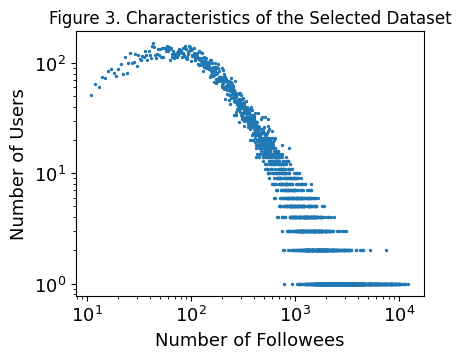

In [52]:
# Characteristics of the Selected Dataset
# X: number of followees
# Y: number of users

u_length = [len(u) for u in Iu_new]
df_length = pd.DataFrame({'length': u_length})
df_dict = df_length.length.value_counts().to_dict()

# Plot
# plt.figure()
plt.figure(figsize=(4.5, 3.5), dpi=100)
plt.scatter(list(df_dict.keys()), list(df_dict.values()), s=2)  # , bins = 500, histtype='step'
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=13) 
plt.yticks(fontsize=13)
plt.title('Figure 3. Characteristics of the Selected Dataset')
plt.xlabel('Number of Followees', fontsize=13)
plt.ylabel('Number of Users', fontsize=13)
plt.show()

## Step 3. Constructing cross-validation dataset

In [53]:
df_folds = pd.DataFrame({'f_lists': Iu_new, 'length': u_length})
df_folds.head(3)

f_lists  length
0  [4, 16, 5, 6, 1, 3, 10, 11, 13, 9, 20, 8, 7, 0...      21
1  [52, 117, 22, 86, 69, 159, 76, 56, 90, 99, 115...     160
2  [180, 188, 202, 233, 241, 184, 207, 215, 224, ...      73

In [64]:
# five folds dataset
Fold1 = []
Fold2 = []
Fold3 = []
Fold4 = []
Fold5 = []

N = 9   # 5%9
for i in range(len(df_folds)):
    fold = df_folds['length'][i] / N
    u_list = df_folds['f_lists'][i]
    Fold1.append(u_list[int(0*fold):int((N-4)*fold)])
    Fold2.append(u_list[int(1*fold):int((N-3)*fold)])
    Fold3.append(u_list[int(2*fold):int((N-2)*fold)])
    Fold4.append(u_list[int(3*fold):int((N-1)*fold)])
    Fold5.append(u_list[int(4*fold):int((N-0)*fold)])
df_folds['Fold1'] = Fold1
df_folds['Fold2'] = Fold2
df_folds['Fold3'] = Fold3
df_folds['Fold4'] = Fold4
df_folds['Fold5'] = Fold5
df_folds.head(3)

In [66]:
# draw 99 negative samples that never been followed by this user
def draw_negative(global_train_test, N=99):
    negative_sample = []
    w = 0
    while w < N:
        item_id = np.random.randint(912150)   # 912150: len(dictionary)
        if item_id in global_train_test:
            pass
        else:
            negative_sample.append(item_id)
            w += 1
    return negative_sample

def update_neg_samples(groups):    
    Fold1_train = []
    Fold1_test = []
    Fold2_train = []
    Fold2_test = []
    Fold3_train = []
    Fold3_test = []
    Fold4_train = []
    Fold4_test = []
    Fold5_train = []
    Fold5_test = []
    
    print(' //// Processing Fold 1')
    Fold = Fold1
    for i in range(len(groups)):
        global_train_test = groups['f_lists'][i]
        # 5%9
        fold = Fold[i]
        cutpoint = len(fold)-1
        batch_train = fold[: cutpoint]
        batch_test = fold[cutpoint: ]
        # negative samples
        negative_sample = draw_negative(global_train_test, N=99)   # update negative samples
        Fold1_train.append(batch_train)
        Fold1_test.append(batch_test+negative_sample)
    
    print(' //// Processing Fold 2')
    Fold = Fold2
    for i in range(len(groups)):
        global_train_test = groups['f_lists'][i]
        fold = Fold[i]
        cutpoint = len(fold)-1
        batch_train = fold[: cutpoint]
        batch_test = fold[cutpoint: ]
        # negative samples
        negative_sample = draw_negative(global_train_test, N=99)   # update negative samples
        Fold2_train.append(batch_train)
        Fold2_test.append(batch_test+negative_sample)
        
    print(' //// Processing Fold 3')    
    Fold = Fold3
    for i in range(len(groups)):
        global_train_test = groups['f_lists'][i]
        fold = Fold[i]
        cutpoint = len(fold)-1
        batch_train = fold[: cutpoint]
        batch_test = fold[cutpoint: ]
        # negative samples
        negative_sample = draw_negative(global_train_test, N=99)   # update negative samples
        Fold3_train.append(batch_train)
        Fold3_test.append(batch_test+negative_sample)
        
    print(' //// Processing Fold 4')
    Fold = Fold4
    for i in range(len(groups)):
        global_train_test = groups['f_lists'][i]
        fold = Fold[i]
        cutpoint = len(fold)-1
        batch_train = fold[: cutpoint]
        batch_test = fold[cutpoint: ]
        # negative samples
        negative_sample = draw_negative(global_train_test, N=99)   # update negative samples
        Fold4_train.append(batch_train)
        Fold4_test.append(batch_test+negative_sample)
        
    print(' //// Processing Fold 5')
    Fold = Fold5
    for i in range(len(groups)):
        global_train_test = groups['f_lists'][i]
        fold = Fold[i]
        cutpoint = len(fold)-1
        batch_train = fold[: cutpoint]
        batch_test = fold[cutpoint: ]
        # negative samples
        negative_sample = draw_negative(global_train_test, N=99)   # update negative samples
        Fold5_train.append(batch_train)
        Fold5_test.append(batch_test+negative_sample)
    
    # save
    df = pd.DataFrame({
        'Fold1_train': Fold1_train, 'Fold1_test': Fold1_test, 'Fold2_train': Fold2_train, 'Fold2_test': Fold2_test, 
        'Fold3_train': Fold3_train, 'Fold3_test': Fold3_test, 'Fold4_train': Fold4_train, 'Fold4_test': Fold4_test, 
        'Fold5_train': Fold5_train, 'Fold5_test': Fold5_test
    })
    return df

# processing
df = update_neg_samples(df_folds)
df.head(2)

 //// Processing Fold 1
 //// Processing Fold 2
 //// Processing Fold 3
 //// Processing Fold 4
 //// Processing Fold 5


Fold1_train  \
0                 [4, 16, 5, 6, 1, 3, 10, 11, 13, 9]   
1  [52, 117, 22, 86, 69, 159, 76, 56, 90, 99, 115...   

                                          Fold1_test  \
0  [20, 570675, 588098, 236315, 250315, 745688, 4...   
1  [118, 807804, 585087, 67693, 370867, 727649, 6...   

                                         Fold2_train  \
0              [5, 6, 1, 3, 10, 11, 13, 9, 20, 8, 7]   
1  [80, 136, 55, 122, 100, 103, 39, 150, 88, 44, ...   

                                          Fold2_test  \
0  [0, 9765, 583956, 424697, 496020, 688768, 1326...   
1  [93, 730280, 538289, 874596, 401536, 247475, 1...   

                                         Fold3_train  \
0             [1, 3, 10, 11, 13, 9, 20, 8, 7, 0, 17]   
1  [57, 116, 114, 164, 21, 46, 109, 59, 158, 41, ...   

                                          Fold3_test  \
0  [15, 179116, 354587, 842865, 131164, 816819, 2...   
1  [139, 419842, 455517, 423396, 670052, 175555, ...   

                                         Fold4_train  \
0               [11, 13, 9, 20, 8, 7, 0, 17, 15, 14]   
1  [42, 54, 140, 61, 157, 60, 129, 176, 119, 127,...   

                                          Fold4_test  \
0  [2, 632702, 123278, 435605, 668177, 225374, 93...   
1  [155, 528908, 594728, 692905, 45997, 287021, 9...   

                                         Fold5_train  \
0            [9, 20, 8, 7, 0, 17, 15, 14, 2, 19, 12]   
1  [147, 28, 29, 75, 152, 45, 163, 92, 63, 65, 26...   

                                          Fold5_test  
0  [18, 473406, 882952, 573526, 909660, 12680, 23...  
1  [37, 558836, 344165, 489780, 444872, 803117, 3...

## Step 4. Constructing Trainset and Testset for C extensions (optional)

In [68]:
# df_train dataset
for n in range(1, 6):
    train = df['Fold'+str(n)+'_train']
    # C style dataframe:  
    user_id = []
    item_id = []
    for u in tqdm(range(len(train))):
        u_list = train[u]
        for j in range(len(u_list)):
            user_id.append(u)
            item_id.append(u_list[j])
    df_train = pd.DataFrame({'id': range(len(item_id)), 'user_id': user_id, 'item_id': item_id})
    # save:
    df_train.to_csv('CV_5%9_group'+str(g)+'_Fold'+str(n)+'_Train.csv', sep=',', index=False)

100%|██████████| 39564/39564 [00:03<00:00, 12606.00it/s]


In [ ]:
# construct 30 groups of negative samples 
for g in range(30):         
    df = update_neg_samples(df_folds)
    for n in range(1, 6): 
        test =  df['Fold'+str(n)+'_test']
        # C style dataframe: 
        user_id = []
        item_id = []
        for u in tqdm(range(len(test))):
            u_list = test[u]
            for j in range(len(u_list)):
                user_id.append(u)
                item_id.append(u_list[j])
        # save:
        df_test = pd.DataFrame({'id': range(len(item_id)), 'user_id': user_id, 'item_id': item_id})
        df_test.reset_index(drop=True)
        df_test.to_csv('CV_5%9_group'+str(g)+'_Fold'+str(n)+'_Groundtruth+99.csv', sep=',', index=False)